In [1]:
import pickle
import os

FOLDER = os.getcwd() + "/4_pts"

with open(FOLDER+'/ori.pkl', 'rb') as file:   
    ori = pickle.load(file)
with open(FOLDER+'/mask.pkl', 'rb') as file:   
    mask = pickle.load(file)
with open(FOLDER+'/out.pkl', 'rb') as file:   
    out = pickle.load(file)
with open(FOLDER+'/psf.pkl', 'rb') as file:   
    original_psf = pickle.load(file)


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [15, 5]
import math
import numpy as np
import random
import time
from utils import *
from Dataloader import *
from PSFNetv2 import *

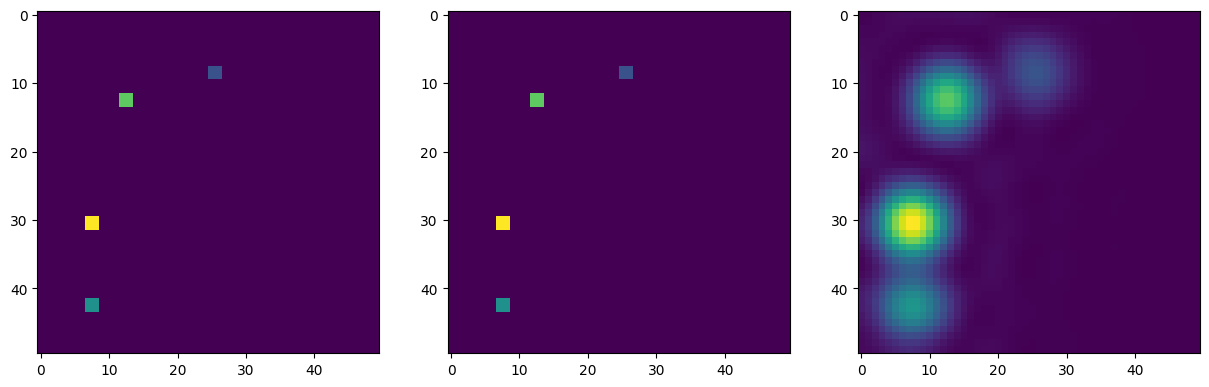

In [3]:
ori = ori/max(ori.flatten())
mask = mask/max(mask.flatten())
out = out/max(out.flatten())

f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(mask)
axarr[2].imshow(out)
plt.show()

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
maskSize = EuclideanDistance((0,0),mask.shape)
sourcePts = GetSourcePts(mask,FOLDER)

#Define dataset and dataloader
dataset = Dataloader(out, mask, adjPts=20, randomPts=0)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=2)

#Define model
model = PSFNet(len(sourcePts),dataset.intensityMatrix.data.flatten())

#Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0)


Best scaling const is:  -10.0


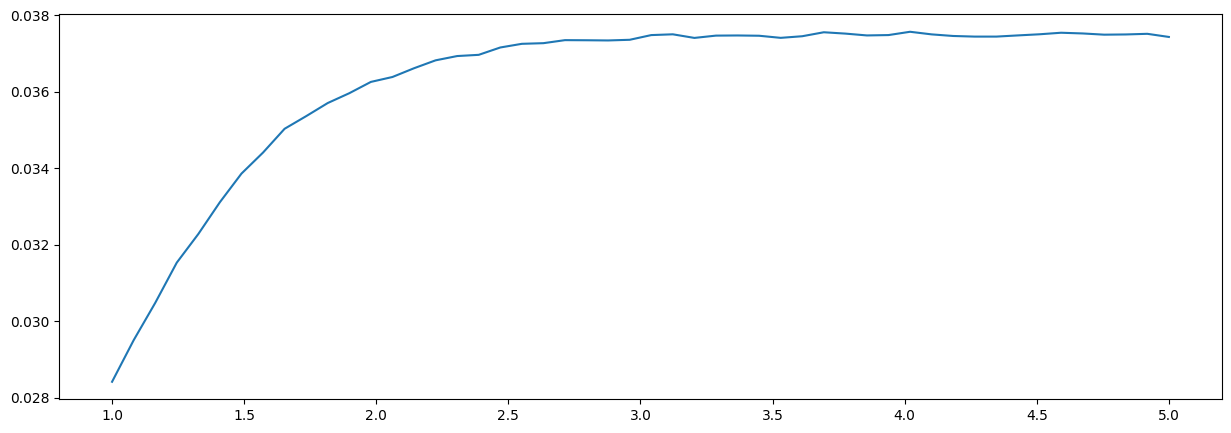

In [6]:
#Perform a global serarch on what the scaling const is
x = np.linspace(1,5,50)
y = []

for i in x:
    model.polynomial_weights.weight.data[0] = -10**i
    average_running_loss = 0
    for j, data in enumerate(dataloader):
        inputs, outputs = data
        nn_outputs = model(inputs)
        loss = criterion(nn_outputs.float(), outputs.float())
        average_running_loss += loss.item()
    average_running_loss /= len(dataloader)
    y.append(average_running_loss)

plt.plot(x,y)
model.polynomial_weights.weight.data[0] = -10**x[np.argmin(y)]
print("Best scaling const is: ", -10**x[np.argmin(y)])

In [7]:
#Training loop

timestr = time.strftime("%Y%m%d-%H%M%S")
PATH = FOLDER + "/model-"+timestr+".pt"
oldOut = out.copy()

TrainingLoop(model,dataloader,criterion,optimizer,epochs=400, minLoss=0.01)

print(model.polynomial_weights.weight.data)

oldOut = InverseMatrix(oldOut,mask,sourcePts,learningRate=1,randomPts=0,adjPts=20,model=model)
oldOut = oldOut/max(oldOut.flatten())

print('Finished Training')


Epoch:  20  Loss:  0.02836347371339798
Epoch:  40  Loss:  0.02838058676570654
Epoch:  60  Loss:  0.028371785767376423
Epoch:  80  Loss:  0.028376220725476742
Epoch:  100  Loss:  0.02839860785752535
Epoch:  120  Loss:  0.028288419358432293
Epoch:  140  Loss:  0.028350524604320526
Epoch:  160  Loss:  0.028369272127747536
Epoch:  180  Loss:  0.02841812279075384
Epoch:  200  Loss:  0.028369867242872715
Epoch:  220  Loss:  0.02837504167109728
Epoch:  240  Loss:  0.028365464881062508
Epoch:  260  Loss:  0.028420650400221348
Epoch:  280  Loss:  0.0283793518319726
Epoch:  300  Loss:  0.028398342430591583
Epoch:  320  Loss:  0.028384613804519176
Epoch:  340  Loss:  0.02839482855051756
Epoch:  360  Loss:  0.028411999344825745
Epoch:  380  Loss:  0.02841859869658947
Epoch:  400  Loss:  0.028385253623127937
Epoch:  400  Loss:  0.028385253623127937
tensor([[-10.]])
[0.25, 0.75, 1.0, 0.5]
[[-0.41605093]
 [ 0.86947745]
 [ 1.        ]
 [ 0.44172481]]
Finished Training


/tmp/ipykernel_5039/2611858017.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  new_psf_y = model.getPSF(torch.tensor(new_psf_x))


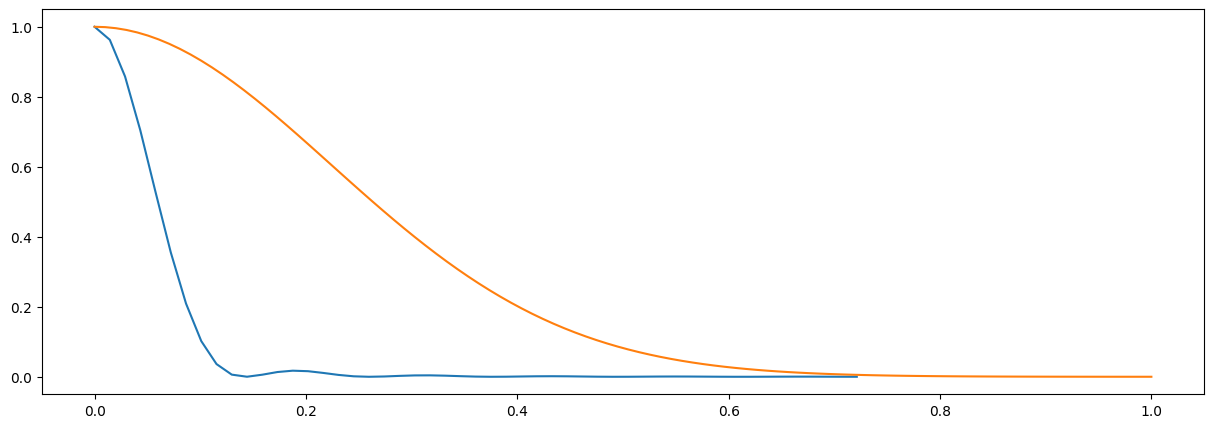

In [8]:
#Normalise x axis of original psf to 1
original_psf_x = np.linspace(0,1,len(original_psf))*len(original_psf)/maskSize
original_psf_y = original_psf
plt.plot(original_psf_x,original_psf_y)

new_psf_x = [np.linspace(0,1,100,dtype=np.float32)]
new_psf_y = model.getPSF(torch.tensor(new_psf_x))
new_psf_x = new_psf_x[0]
new_psf_y = new_psf_y.detach().numpy().flatten()
new_psf_y = new_psf_y/max(new_psf_y.flatten())
plt.plot(new_psf_x,new_psf_y)
plt.show()


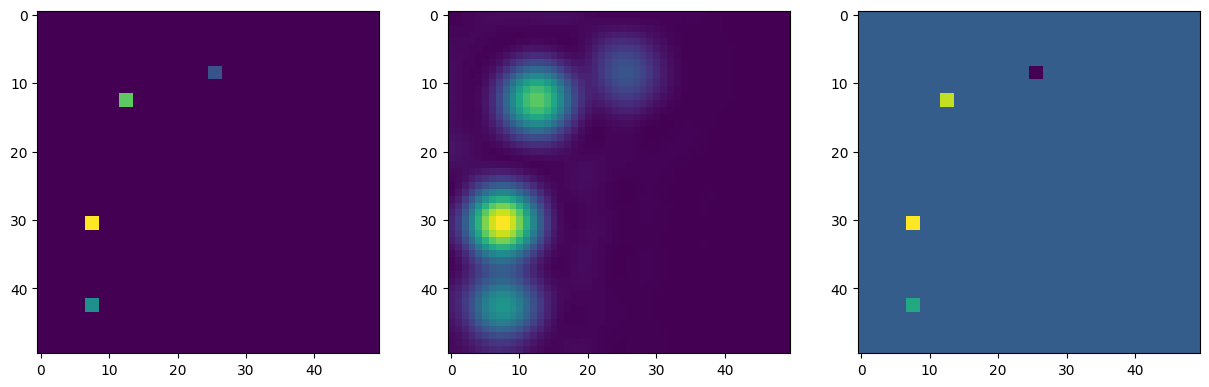

In [9]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(out)
axarr[2].imshow(oldOut)
plt.show()


array([[1.        , 0.94417062],
       [0.94417062, 1.        ]])

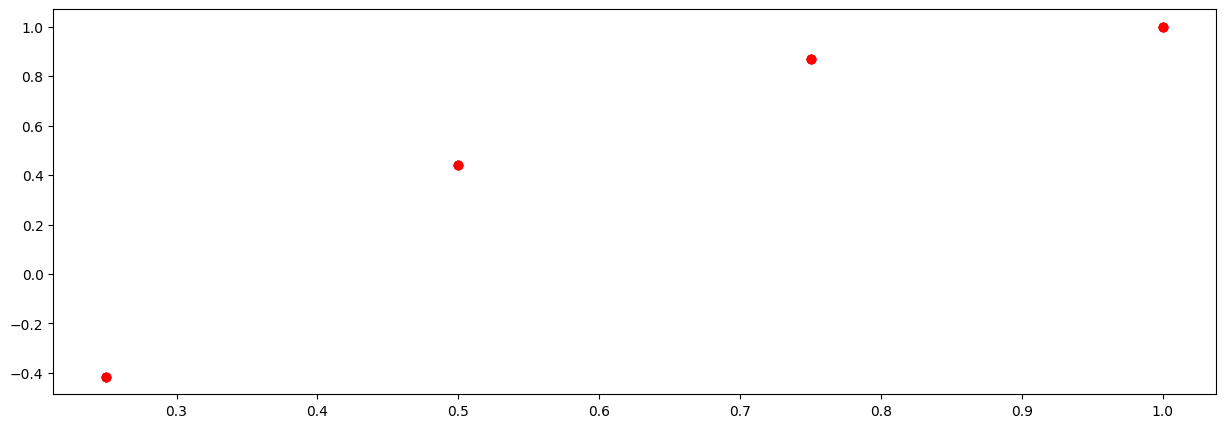

In [10]:
original_intensity = []
custom_intensity = []


for x in sourcePts:
    original_intensity.append(ori[x[0],x[1]])
    custom_intensity.append(oldOut[x[0],x[1]])

plt.plot(original_intensity,custom_intensity,'ro')

#Calculate correlation coefficient
np.corrcoef(original_intensity,custom_intensity)